<a href="https://colab.research.google.com/github/taeddy/Neuron_CNN_Interpretation/blob/main/Neuron_CNN_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## import

In [ ]:
import os
import pandas as pd
import time
import cv2
import numpy as np

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss

from torchsummary import summary

from torchvision.io import read_image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# 데이터 확장 (Data Augmentation)을 위한 함수
def _blend(img1, img2, ratio):
    ratio = float(ratio)
    bound = 1.0 if img1.is_floating_point() else 255.0
    return (ratio * img1 + (1.0 - ratio) * img2).clamp(0, bound).to(img1.dtype)

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, trans_p=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.trans_p = trans_p

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.trans_p:
            if self.trans_p >= torch.rand(1):
                brightness = 1.5
                contrast = 1.5
                brightness_factor = float(torch.empty(1).uniform_(max(0.01, 1-brightness), 1+brightness))
                contrast_factor = float(torch.empty(1).uniform_(max(0.01, 1-contrast), 1+contrast))

                image = _blend(image, torch.zeros_like(image), brightness_factor)
                mean = torch.mean(image.to(torch.float32), dim=(-3, -2, -1), keepdim=True)
                image = _blend(image, mean, contrast_factor)

        return image, label, img_path

## datasets

In [ ]:
path_label_train = '../Data/new_data_210928/DataSet/0-5_stim/Area3_POD3/label_train.csv'
path_label_test = '../Data/new_data_210928/DataSet/0-5_stim/Area3_POD3/label_test.csv'

path_data_train = '../Data/new_data_210928/DataSet/0-5_stim/Area3_POD3/train'
path_data_test = '../Data/new_data_210928/DataSet/0-5_stim/Area3_POD3/test'
# path_data_train = '../Data/new_data_210928/DataSet/0-5_stim/Area3/mask/train'
# path_data_test = '../Data/new_data_210928/DataSet/0-5_stim/Area3/mask/test'

ds_train = CustomImageDataset(annotations_file=path_label_train, img_dir=path_data_train, trans_p=0.5)
ds_train2 = CustomImageDataset(annotations_file=path_label_train, img_dir=path_data_train)
ds_test = CustomImageDataset(annotations_file=path_label_test, img_dir=path_data_test)

trainloader = DataLoader(ds_train, batch_size=10, shuffle=True)
trainloader2 = DataLoader(ds_train2, batch_size=10, shuffle=False)
testloader = DataLoader(ds_test, batch_size=1, shuffle=False)

check loader

Feature batch shape: torch.Size([10, 1, 512, 512])
Labels batch shape: torch.Size([10])


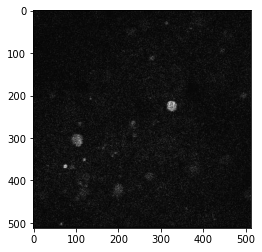

Label: 10 ../Data/new_data_210928/DataSet/0-5_stim/Area3_POD3/train/POD3_Area3_1_010_125.jpg


In [ ]:
train_features, train_labels, fn = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}", fn[0])

## CNN model

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*60*60, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64*60*60)
        x = self.classifier(x)
        return x

### model summary

In [ ]:
model = Net(num_classes=25)
model.to('cuda')
summary(model, input_size=(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 508, 508]             416
              ReLU-2         [-1, 16, 508, 508]               0
         MaxPool2d-3         [-1, 16, 254, 254]               0
            Conv2d-4         [-1, 32, 250, 250]          12,832
              ReLU-5         [-1, 32, 250, 250]               0
         MaxPool2d-6         [-1, 32, 125, 125]               0
            Conv2d-7         [-1, 64, 121, 121]          51,264
              ReLU-8         [-1, 64, 121, 121]               0
         MaxPool2d-9           [-1, 64, 60, 60]               0
           Linear-10                  [-1, 300]      69,120,300
             ReLU-11                  [-1, 300]               0
           Linear-12                   [-1, 25]           7,525
Total params: 69,192,337
Trainable params: 69,192,337
Non-trainable params: 0
-------------------------

## methods

In [ ]:
def LabelToTensor(pred, label):
    labeltensor = torch.zeros_like(pred)

    lt = pd.read_csv('./LT_Area3.csv', header=None)
#     print(lt)
    idx = label.item() - 1
    label1 = lt.iloc[idx, 0]
    label2 = lt.iloc[idx, 1]
#     print('label1 =',label1, 'label2 =',label2)

    if label2 == 0:
        labeltensor[label1-1] = 1
    else:
        labeltensor[label1-1] = 1
        labeltensor[label2-1] = 1

    return labeltensor

def evaluate(model=model, dataloader=testloader, device='cuda', printout=False):
    if printout:
        print('Using {} device'.format(device))
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data, label, fn in dataloader:
            data = data.float().to(device)
            for idx, l in enumerate(label):
                outputs = model(data[idx].view(1,1,512,512))
                outputs = outputs.reshape([-1])
                l.to(device)
                labelT = LabelToTensor(outputs, l)

                outputs_sort = outputs.sort()
                labelT_sort = labelT.sort()

                total += 1
                if l <= 8 or (l >= 37 and l <= 44) or (l >= 73 and l <= 80) or l == 109:
                    if outputs_sort.indices[-1] == labelT_sort.indices[-1]:
                        correct += 1
                else:
                    if outputs_sort.indices[-1] == labelT_sort.indices[-1] or outputs_sort.indices[-2] == labelT_sort.indices[-2]:
                        correct += 1
                    elif outputs_sort.indices[-1] == labelT_sort.indices[-2] or outputs_sort.indices[-2] == labelT_sort.indices[-1]:
                        correct += 1
    if printout:
        print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

    return (100 * correct / total)


## criterion, opimizer

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model.to(device)
model.train()

acc_train_his = []
acc_test_his = []
loss_his = [] # loss for TRAIN dataset, calculated every epoch

start_epoch, max_epoch = 0, 30

start_time = time.time()

for epoch in range(start_epoch, max_epoch):
    running_loss = 0.0

    for i, (data, label, fname) in enumerate(trainloader):
        data = data.float().to(device)
        label = label.to(device)
        pred = model(data)

        labelT = torch.Tensor().to(device)
        for idx, l in enumerate(label):
            if idx == 0:
                labelT = LabelToTensor(pred[0], l)
                labelT = labelT.reshape([1,pred.size()[1]])
            else:
                labelT = torch.cat([labelT, LabelToTensor(pred[0], l).reshape([1,pred.size()[1]])], dim=0)

        pred = torch.sigmoid(pred) # sigmoid for BCELoss
        loss = criterion(pred, labelT)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    trainacc = evaluate(model, trainloader)
    testacc = evaluate(model, testloader)

    loss_his.append(running_loss/len(trainloader))
    acc_train_his.append(trainacc)
    acc_test_his.append(testacc)
    print('Epoch {:d}/{}, Loss avg: {:.6f}, trainacc: {:.1f}%, testacc: {:.1f}%'\
          .format(epoch, max_epoch, running_loss/len(trainloader), trainacc, testacc))

elapsed_time = time.time() - start_time
print('Finished Training')
print ("elapsed_time: %d [sec]" % (elapsed_time))

Using cuda device
Epoch 0/30, Loss avg: 0.192204, trainacc: 87.5%, testacc: 80.9%
Epoch 1/30, Loss avg: 0.086102, trainacc: 94.7%, testacc: 85.8%
Epoch 2/30, Loss avg: 0.055948, trainacc: 95.9%, testacc: 85.2%
Epoch 3/30, Loss avg: 0.035569, trainacc: 97.7%, testacc: 84.8%
Epoch 4/30, Loss avg: 0.023900, trainacc: 99.0%, testacc: 86.7%
Epoch 5/30, Loss avg: 0.019794, trainacc: 98.4%, testacc: 84.2%
Epoch 6/30, Loss avg: 0.016163, trainacc: 99.2%, testacc: 87.1%
Epoch 7/30, Loss avg: 0.013372, trainacc: 99.4%, testacc: 87.1%
Epoch 8/30, Loss avg: 0.010694, trainacc: 99.0%, testacc: 84.4%
Epoch 9/30, Loss avg: 0.011757, trainacc: 99.5%, testacc: 85.4%
Epoch 10/30, Loss avg: 0.011136, trainacc: 99.6%, testacc: 86.4%
Epoch 11/30, Loss avg: 0.010828, trainacc: 99.1%, testacc: 84.8%
Epoch 12/30, Loss avg: 0.007956, trainacc: 99.7%, testacc: 86.0%
Epoch 13/30, Loss avg: 0.007764, trainacc: 99.2%, testacc: 80.9%
Epoch 14/30, Loss avg: 0.006402, trainacc: 99.3%, testacc: 83.9%
Epoch 15/30, Loss

## acc, loss history

### no masking

[80.93952483801296, 85.79913606911447, 85.1511879049676, 84.7732181425486, 86.7170626349892, 84.23326133909288, 87.0950323974082, 87.0950323974082, 84.44924406047517, 85.42116630669547, 86.39308855291577, 84.7732181425486, 86.01511879049676, 80.88552915766739, 83.85529157667386, 85.1511879049676, 86.01511879049676, 85.25917926565874, 84.61123110151188, 87.20302375809935, 82.93736501079914, 86.33909287257019, 86.7170626349892, 85.85313174946005, 84.12526997840173, 82.9913606911447, 85.63714902807776, 84.28725701943844, 85.20518358531318, 85.42116630669547]
[87.54936120789779, 94.72706155632984, 95.90011614401858, 97.73519163763066, 99.00116144018583, 98.3507549361208, 99.15214866434378, 99.38443670150987, 98.95470383275261, 99.465737514518, 99.60511033681766, 99.07084785133566, 99.69802555168408, 99.2102206736353, 99.30313588850174, 99.65156794425087, 99.61672473867596, 99.4773519163763, 99.69802555168408, 99.77932636469222, 99.51219512195122, 99.77932636469222, 99.732868757259, 99.7560

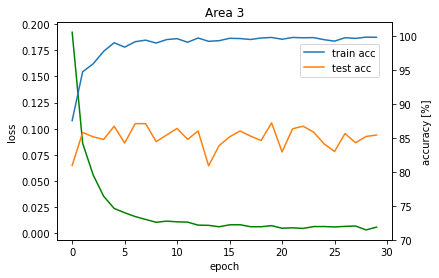

In [ ]:
# no mask
print(acc_test_his)
print(acc_train_his)
print(loss_his)

x = np.arange(30)

plt.figure()
plt.title('Area 3')
plt.plot(x, loss_his, 'g', label='train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.twinx()
plt.plot(x, acc_train_his, label='train acc')
plt.plot(x, acc_test_his, label='test acc')
plt.ylim([70,102])
plt.ylabel('accuracy [%]')
plt.legend(loc=(0.725,0.75))

plt.show()

### with masking

[80.0, 85.72207084468666, 89.1008174386921, 88.8283378746594, 89.48228882833787, 86.86648501362397, 90.02724795640327, 89.80926430517711, 88.99182561307902, 89.97275204359673, 86.7574931880109, 90.29972752043597, 90.35422343324251, 90.57220708446866, 89.70027247956403, 90.13623978201635, 89.42779291553134, 91.28065395095368, 90.35422343324251, 91.82561307901908, 89.9182561307902, 90.13623978201635, 90.29972752043597, 90.35422343324251, 90.13623978201635, 90.57220708446866, 88.50136239782016, 87.62942779291554, 89.75476839237058, 89.59128065395096]
[83.21416012190834, 89.8839526433009, 93.98663697104676, 95.04161294103857, 96.50685734380495, 95.07677880670497, 97.51494549290821, 98.22998476145821, 97.81971632868363, 98.69886297034346, 97.73766264212871, 99.00363380611886, 99.08568749267378, 98.96846794045247, 99.17946313445083, 99.1325753135623, 99.21462900011721, 99.05052162700738, 99.27323877622787, 99.29668268667214, 99.20290704489508, 99.10913140311804, 99.12085335834017, 99.3670144

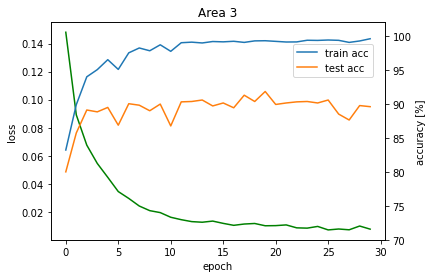

In [ ]:
# with mask
print(acc_test_his)
print(acc_train_his)
print(loss_his)

x = np.arange(30)

plt.figure()
plt.title('Area 3')
plt.plot(x, loss_his, 'g', label='train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.twinx()
plt.plot(x, acc_train_his, label='train acc')
plt.plot(x, acc_test_his, label='test acc')
plt.ylim([70,102])
plt.ylabel('accuracy [%]')
plt.legend(loc=(0.725,0.75))

plt.show()

# Test

In [ ]:
evaluate(model=model, dataloader=trainloader, device='cuda', printout=True)
evaluate(model=model, dataloader=trainloader2, device='cuda', printout=True)
evaluate(model=model, dataloader=testloader, device='cuda', printout=True)

Using cuda device
Accuracy of the network on the 8610 test images: 99 %
Using cuda device
Accuracy of the network on the 8610 test images: 100 %
Using cuda device
Accuracy of the network on the 1852 test images: 85 %


85.42116630669547

## Accuracy per Cell

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
# device = 'cpu'
print('Using {} device'.format(device))
model.to(device)
model.eval()

# accuracy per label
total_label = [0 for i in range(110)]
correct_label = [0 for i in range(110)]
dup = False

num_classes = 25
classes = np.array(range(num_classes))+1
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct_pred_1c = {classname: 0 for classname in classes}
total_pred_1c = {classname: 0 for classname in classes}
correct_pred_2c = {classname: 0 for classname in classes}
total_pred_2c = {classname: 0 for classname in classes}

with torch.no_grad():
    for data, label, fn in testloader:
        data = data.float().to(device)
        for idx, l in enumerate(label):
            outputs = model(data[idx].view(1,1,512,512))
            outputs = outputs.reshape([-1])
            labelT = LabelToTensor(outputs, l)

            outputs_sort = outputs.sort()
            labelT_sort = labelT.sort()

            total_label[l] += 1

            # 1 cell stimulation
            # 출력을 1개의 세포라고 생각했을 때
            if l <= 8 or (l >= 37 and l <= 44) or (l >= 73 and l <= 80) or l == 109:
                total_pred[classes[labelT_sort.indices[-1]]] += 1
                total_pred_1c[classes[labelT_sort.indices[-1]]] += 1
                if outputs_sort.indices[-1] == labelT_sort.indices[-1]:
                    correct_pred[classes[outputs_sort.indices[-1]]] += 1
                    correct_pred_1c[classes[outputs_sort.indices[-1]]] += 1
                    correct_label[l]+=1

            # 2 cells stimulation
            # 패턴 분석에 의의를 두고 결과치가 높은 두개의 세포를 예측할 때
            else:
                total_pred[classes[labelT_sort.indices[-1]]] += 1
                total_pred[classes[labelT_sort.indices[-2]]] += 1
                total_pred_2c[classes[labelT_sort.indices[-1]]] += 1
                total_pred_2c[classes[labelT_sort.indices[-2]]] += 1
                if outputs_sort.indices[-1] == labelT_sort.indices[-1] or outputs_sort.indices[-1] == labelT_sort.indices[-2]:
                    correct_pred[classes[outputs_sort.indices[-1]]] += 1
                    correct_pred_2c[classes[outputs_sort.indices[-1]]] += 1
                    correct_label[l]+=1; dup = True
                if outputs_sort.indices[-2] == labelT_sort.indices[-1] or outputs_sort.indices[-2] == labelT_sort.indices[-2]:
                    correct_pred[classes[outputs_sort.indices[-2]]] += 1
                    correct_pred_2c[classes[outputs_sort.indices[-2]]] += 1
                    if dup == False:
                        correct_label[l]+=1
                dup = False

Using cuda device


acc per all stim

{1: 80, 2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 7: 80, 8: 80, 9: 80, 10: 80, 11: 80, 12: 79, 13: 80, 14: 80, 15: 79, 16: 80, 17: 80, 18: 80, 19: 80, 20: 80, 21: 80, 22: 80, 23: 80, 24: 80, 25: 756}
{1: 76, 2: 71, 3: 60, 4: 63, 5: 48, 6: 44, 7: 48, 8: 52, 9: 73, 10: 72, 11: 51, 12: 56, 13: 62, 14: 57, 15: 48, 16: 74, 17: 71, 18: 68, 19: 65, 20: 51, 21: 69, 22: 47, 23: 51, 24: 64, 25: 732}
Accuracy for class     1 is: 95.0 %
Accuracy for class     2 is: 88.8 %
Accuracy for class     3 is: 75.0 %
Accuracy for class     4 is: 78.8 %
Accuracy for class     5 is: 60.0 %
Accuracy for class     6 is: 55.0 %
Accuracy for class     7 is: 60.0 %
Accuracy for class     8 is: 65.0 %
Accuracy for class     9 is: 91.2 %
Accuracy for class    10 is: 90.0 %
Accuracy for class    11 is: 63.8 %
Accuracy for class    12 is: 70.9 %
Accuracy for class    13 is: 77.5 %
Accuracy for class    14 is: 71.2 %
Accuracy for class    15 is: 60.8 %
Accuracy for class    16 is: 92.5 %
Accuracy for class    17 is: 88.8 %
Ac

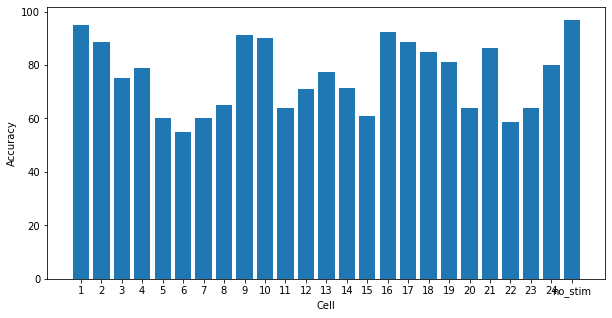

In [ ]:
print(total_pred)
print(correct_pred)
acc_class = np.zeros(num_classes+1)
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5d} is: {:.1f} %".format(classname,
                                                   accuracy))
    acc_class[classname] = accuracy
acc_class = np.delete(acc_class, [0])
# print(acc_class)

x = np.arange(num_classes)
cell_no = np.arange(num_classes)+1
cell_no = cell_no.astype(np.str)
cell_no[-1] = 'no_stim'

plt.figure(figsize=(10,5))
plt.bar(x, acc_class)
plt.xticks(x, cell_no)
plt.xlabel('Cell')
plt.ylabel('Accuracy')

plt.show()

acc per cell, 1 cell stim

{1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 756}
{1: 9, 2: 6, 3: 4, 4: 5, 5: 2, 6: 6, 7: 6, 8: 6, 9: 8, 10: 7, 11: 0, 12: 5, 13: 5, 14: 8, 15: 8, 16: 9, 17: 9, 18: 6, 19: 5, 20: 2, 21: 6, 22: 5, 23: 3, 24: 5, 25: 732}
Accuracy for class     1 is: 90.0 %
Accuracy for class     2 is: 60.0 %
Accuracy for class     3 is: 40.0 %
Accuracy for class     4 is: 50.0 %
Accuracy for class     5 is: 20.0 %
Accuracy for class     6 is: 60.0 %
Accuracy for class     7 is: 60.0 %
Accuracy for class     8 is: 60.0 %
Accuracy for class     9 is: 80.0 %
Accuracy for class    10 is: 70.0 %
Accuracy for class    11 is: 0.0 %
Accuracy for class    12 is: 50.0 %
Accuracy for class    13 is: 50.0 %
Accuracy for class    14 is: 80.0 %
Accuracy for class    15 is: 80.0 %
Accuracy for class    16 is: 90.0 %
Accuracy for class    17 is: 90.0 %
Accuracy for class    18 is

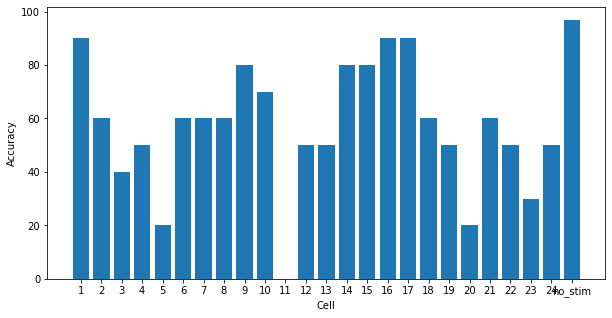

In [ ]:
print(total_pred_1c)
print(correct_pred_1c)
acc_class = np.zeros(num_classes+1)
for classname, correct_count in correct_pred_1c.items():
    accuracy = 100 * float(correct_count) / total_pred_1c[classname]
    print("Accuracy for class {:5d} is: {:.1f} %".format(classname,
                                                   accuracy))
    acc_class[classname] = accuracy
acc_class = np.delete(acc_class, [0])
# print(acc_class)

x = np.arange(num_classes)
cell_no = np.arange(num_classes)+1
cell_no = cell_no.astype(np.str)
cell_no[-1] = 'no_stim'

plt.figure(figsize=(10,5))
plt.bar(x, acc_class)
plt.xticks(x, cell_no)
plt.xlabel('Cell')
plt.ylabel('Accuracy')

plt.show()

acc per cell, 2 cells stim

{1: 70, 2: 70, 3: 70, 4: 70, 5: 70, 6: 70, 7: 70, 8: 70, 9: 70, 10: 70, 11: 70, 12: 69, 13: 70, 14: 70, 15: 69, 16: 70, 17: 70, 18: 70, 19: 70, 20: 70, 21: 70, 22: 70, 23: 70, 24: 70, 25: 0}
{1: 58, 2: 63, 3: 55, 4: 49, 5: 41, 6: 29, 7: 34, 8: 60, 9: 64, 10: 49, 11: 51, 12: 56, 13: 39, 14: 62, 15: 50, 16: 60, 17: 57, 18: 63, 19: 57, 20: 42, 21: 64, 22: 42, 23: 53, 24: 56, 25: 0}
Accuracy for class     1 is: 82.9 %
Accuracy for class     2 is: 90.0 %
Accuracy for class     3 is: 78.6 %
Accuracy for class     4 is: 70.0 %
Accuracy for class     5 is: 58.6 %
Accuracy for class     6 is: 41.4 %
Accuracy for class     7 is: 48.6 %
Accuracy for class     8 is: 85.7 %
Accuracy for class     9 is: 91.4 %
Accuracy for class    10 is: 70.0 %
Accuracy for class    11 is: 72.9 %
Accuracy for class    12 is: 81.2 %
Accuracy for class    13 is: 55.7 %
Accuracy for class    14 is: 88.6 %
Accuracy for class    15 is: 72.5 %
Accuracy for class    16 is: 85.7 %
Accuracy for class    17 is: 81.4 %
Accura

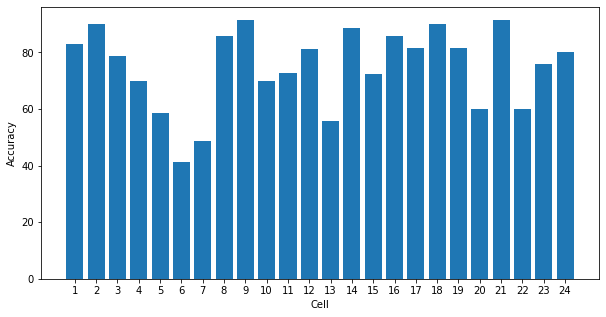

In [ ]:
print(total_pred_2c)
print(correct_pred_2c)
acc_class = np.zeros(num_classes)
for classname, correct_count in correct_pred_2c.items():
    if classname == 25: continue
    accuracy = 100 * float(correct_count) / total_pred_2c[classname]
    print("Accuracy for class {:5d} is: {:.1f} %".format(classname,
                                                   accuracy))
    acc_class[classname] = accuracy
acc_class = np.delete(acc_class, [0])
# print(acc_class)

x = np.arange(num_classes-1)
cell_no = np.arange(num_classes-1)+1

plt.figure(figsize=(10,5))
plt.bar(x, acc_class)
plt.xticks(x, cell_no)
plt.xlabel('Cell')
plt.ylabel('Accuracy')

plt.show()

# save / load model

In [ ]:
torch.save(model.state_dict(), './models/Area3_POD3_25c_5f_epoch30_no_mask.pth')
# torch.save(model.state_dict(), './models/Area3_POD3_25c_5f_epoch30_mask.pth')

In [ ]:
model.load_state_dict(torch.load('./models/Area3_POD3_25c_5f_epoch30_no_mask.pth'))

<All keys matched successfully>

# Grad-CAM

## import

In [ ]:
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 마지막 레이어의 역전파 구배를 기록
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 마지막 레이어의 출력 feature를 기록
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]])
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

    def __call__(self, input, input_size, label=-1):
        # forward 계산
        input = input.float()
        model_output = self.forward(input)
        if label == -1:
            target = model_output.argmax(1).item()
        else:
            target = label
        # backward계산
        self.backward_on_target(model_output, target)

        # feature_layer 의 gradient를 저장
        feature_grad = self.feature_grad.data
        # gradient 를 global average pooling
        weights = feature_grad.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
        # feature_layer 의 activation map 저장
        feature_map = self.feature_map.data
        # 가중치를 부여하여 ReLU
        cam = torch.relu((weights * feature_map).sum(dim=1)).squeeze(0)

        # cam을 출력하기 위한 변형
        cam = cam.numpy()
        #cam = np.maximum(cam, 0)  # apply ReLU to cam
        cam = cv2.resize(cam, input_size)
        if np.max(cam) - np.min(cam) > 0:
            cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

        # hooks 비우기
        #self.clear_hook()

        return cam

def show_cam_on_image(img, mask, img_size):
    # MASK 를 8비트화, 히스토그램 생성
    heatmap_img = cv2.applyColorMap(np.uint8(255*img), cv2.COLORMAP_JET)
    heatmap_mask = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_BONE)
    # 원본과 합침
    cam = (np.float32(heatmap_mask) + np.float32(heatmap_img))
    if np.max(cam) > 0:
        cam = cam / np.max(cam)
    # 원본 사이즈로 복원
    cam = cv2.resize(cam, img_size)
    # 출력
    cv2.imwrite("cam.jpg", np.uint8(255 * cam)) # jpgで保存
    pl.figure(figsize=(16,10))
    pl.subplot(1,3,1)
    pl.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
    pl.subplot(1,3,2)
    pl.imshow(cv2.cvtColor(heatmap_mask, cv2.COLOR_BGR2RGB))
    pl.subplot(1,3,3)
    pl.imshow(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB))

def show_cam_on_image2(img, mask, img_size, f):
    floor = 0.1 #정규화 마스크의 최소값
    # 8비트화, 히스토그램 생성
    heatmap_img = cv2.applyColorMap(np.uint8(255*img), cv2.COLORMAP_BONE)
    heatmap_mask = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_BONE)

    # mask를 정규화
    if np.max(mask) > np.min(mask):
        mask_nrm = (1.0 - floor)*(mask -np.min(mask)) / (np.max(mask)-np.min(mask)) + floor
    else:
        mask_nrm = mask
    mask_mat = np.transpose(np.tile(mask_nrm,(3,1,1)), (1,2,0))

    # 원본과 합침
    cam = mask_mat * np.float32(heatmap_img)
    if np.max(cam) > 0:
        cam = cam / np.max(cam)
    # 원본 사이즈로 복원
    cam = cv2.resize(cam, img_size)
    # 출력
    cv2.imwrite("cam_images/Area3/out/out_"+f, np.uint8(255 * cam)) # jpgで保存
    cv2.imwrite("cam_images/Area3/cam/cam_"+f, heatmap_mask) # jpgで保存

    plt.figure(figsize=(16,10))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
    plt.title(f)
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(heatmap_mask, cv2.COLOR_BGR2RGB))
    plt.title(f)
#     plt.subplot(1,3,3)
#     plt.imshow(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB))
#     plt.title(str(label)+'_'+str(count))

def corrcoef(x):
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1).reshape(x.size()[0],-1)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c))
    c = c.div(stddev.expand_as(c).t())

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

In [ ]:
# 원본을 224*224 로 정규화
#img = np.float32(np.array(image.resize((224,224)))) /255
#show_cam_on_image(img, cam, image_orig_size)

Input_Size = (512,512)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
unnormalize = transforms.Compose([transforms.Normalize((0.0, ), (1.0/0.5, )), transforms.Normalize((-0.5, ), (1.0, ))])

cummodel = model.to("cpu")
grad_cam = GradCAM(model=cummodel, feature_layer=list(cummodel.features.modules())[-1])
print('Grad-CAM target:',list(cummodel.features.modules())[-1])

# target_label = 1
counter=0
cam1 = np.zeros(Input_Size)
cam2 = np.zeros(Input_Size)
# cam1 target = 1, cam2 target = 3

for i, (images, labels, fn) in enumerate(trainloader2, 0):
    for idx, l in enumerate(labels):
        if(l == 1 or l == 3):
            counter += 1
            while counter <= 80:
                outputs = model.to("cpu")(images.float()[idx].view(1,1,512,512))
                outputs = outputs.reshape([-1])
                outputs_sort = outputs.sort()
                label = l
                labelT = LabelToTensor(outputs, label)

                outputs_sort = outputs.sort()
                labelT_sort = labelT.sort()
                print(fn[idx])
                print(outputs_sort.indices[-2:])

                f = os.path.basename(fn[idx])


                cam = grad_cam(images.to("cpu")[idx].view(1,1,512,512), Input_Size)
                if l == 1:
                    cam1 += cam
                elif l == 3:
                    cam2 += cam
#                 heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_BONE)
                t_img = torchvision.utils.make_grid(images[idx].view(1,1,512,512))
                t_img = t_img.float()
                img = unnormalize(t_img)
                img = np.transpose(img.numpy(),(1,2,0))
#                 show_cam_on_image2(img, cam, Input_Size, f)
                if counter%80 == 0:
                    cam1 /= 40
                    cam2 /= 40
                    show_cam_on_image2(img, cam1, Input_Size, f)
                    show_cam_on_image2(img, cam2, Input_Size, f)
#                     temp = np.zeros(Input_Size)
                break

## execute CAM

In [ ]:
Input_Size = (512,512)

cummodel = model.to("cpu")
grad_cam = GradCAM(model=cummodel, feature_layer=list(cummodel.features.modules())[-1])
print('Grad-CAM target:',list(cummodel.features.modules())[-1])

# store cam mean
cams = torch.zeros(109,512,512)

for i, (images, labels, fn) in enumerate(trainloader2, 0):
    print('batch %3d / %d'%(i, len(trainloader2)))
    for idx, l in enumerate(labels):
        outputs = model.to("cpu")(images.float()[idx].view(1,1,512,512))
        outputs = outputs.reshape([-1])
        outputs_sort = outputs.sort()
        label = l
        labelT = LabelToTensor(outputs, label)
        outputs_sort = outputs.sort()
        labelT_sort = labelT.sort()
#         print(fn[idx])
#         print(outputs_sort.indices[-2:])

        f = os.path.basename(fn[idx])

        cam = grad_cam(images.to("cpu")[idx].view(1,1,512,512), Input_Size)
        cams[l-1] += cam
cams /= 40

## plot result

In [ ]:
# cam에는 109개의 세포 자극에 대한 CAM결과(512*512) 가 저장되어 있음
print(cams.size())
# 109개의 cam 결과를 상관분석
co = corrcoef(cams.reshape(109,-1))

torch.Size([109, 512, 512])


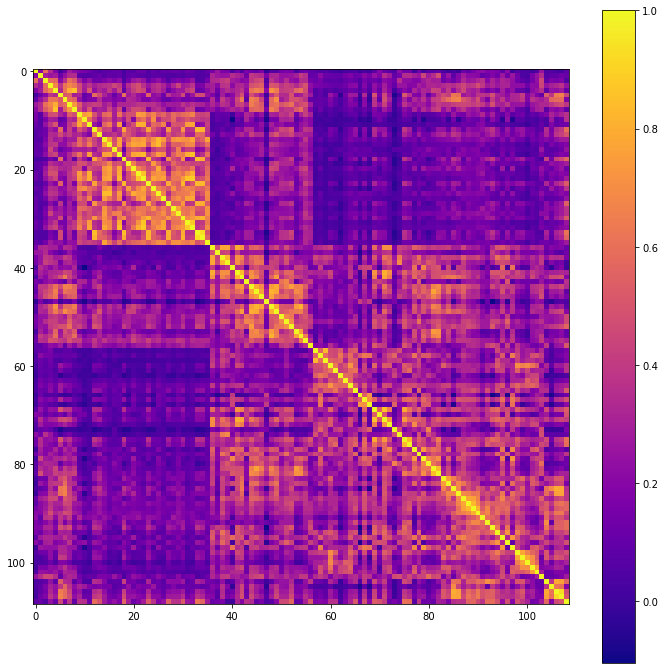

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(co, cmap='plasma')
plt.colorbar()

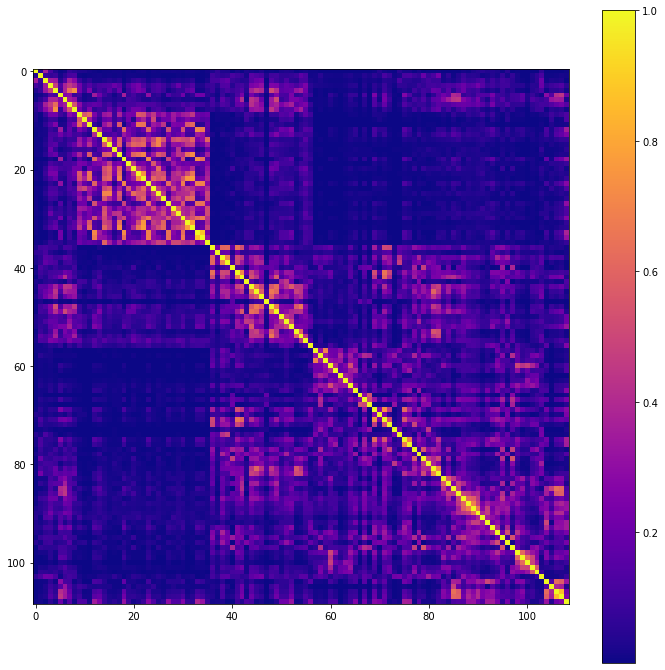

In [ ]:
R2 = co*co
plt.figure(figsize=(12,12))
plt.imshow(R2, cmap='plasma')
plt.colorbar()

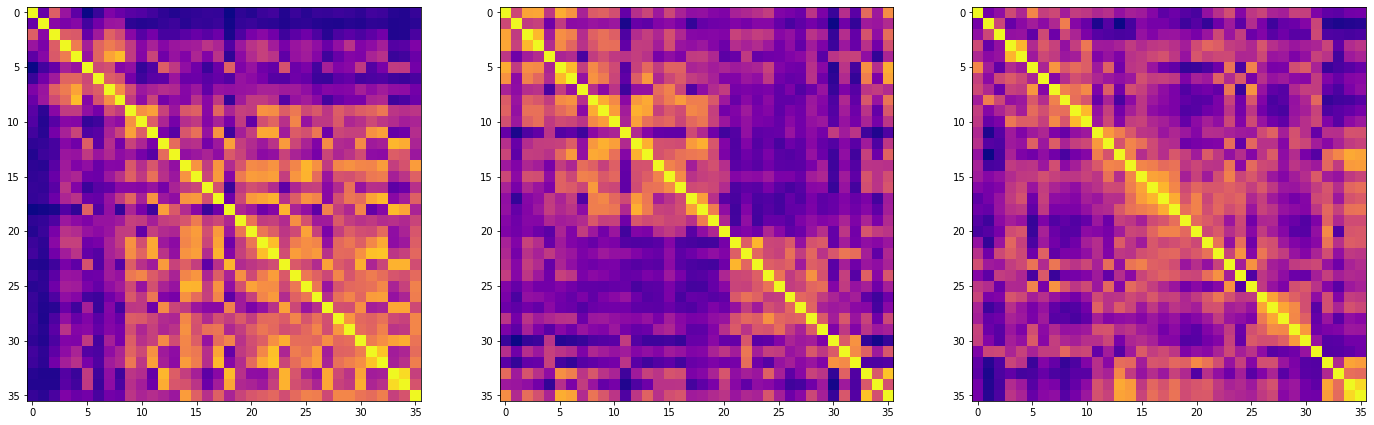

In [ ]:
plt.figure(figsize=(24,24))
plt.subplot(1,3,1)
plt.imshow(co[0:36,0:36], cmap='plasma')
plt.subplot(1,3,2)
plt.imshow(co[36:72,36:72], cmap='plasma')
plt.subplot(1,3,3)
plt.imshow(co[72:108,72:108], cmap='plasma')